# 凸性
:label:`sec_convexity`

凸性在优化算法的设计中起着至关重要的作用。
这主要是因为在这样的背景下分析和测试算法要容易得多。
换句话说，
如果算法即使在凸设定下表现也很差，
通常我们不应该期望在其他情况下看到很好的结果。
此外，尽管深度学习中的优化问题通常是非凸的，但它们在局部最小值附近往往表现出一些凸性质。这可以导致令人兴奋的新优化变体，例如 :cite:`Izmailov.Podoprikhin.Garipov.ea.2018`。

In [1]:
%matplotlib inline
import numpy as np
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l

## 定义

在凸分析之前，我们需要定义*凸集*和*凸函数*。它们引出了常用于机器学习的数学工具。

### 凸集

集合是凸性的基础。简单来说，向量空间中的一个集合 $\mathcal{X}$ 是*凸集*，如果对于任意 $a, b \in \mathcal{X}$ 连接 $a$ 和 $b$ 的线段也属于 $\mathcal{X}$。用数学语言表示就是，对于所有 $\lambda \in [0, 1]$ 我们有

$$\lambda  a + (1-\lambda)  b \in \mathcal{X} \textrm{ 只要 } a, b \in \mathcal{X}.$$

这听起来有点抽象。考虑 :numref:`fig_pacman`。第一个集合不是凸的，因为存在不包含在其内的线段。其他两个集合没有这个问题。

![第一个集合是非凸的，而另外两个是凸的。](../img/pacman.svg)
:label:`fig_pacman`

定义本身并不特别有用，除非你能用它们做些什么。在这种情况下，我们可以查看交集，如 :numref:`fig_convex_intersect` 所示。假设 $\mathcal{X}$ 和 $\mathcal{Y}$ 是凸集。那么 $\mathcal{X} \cap \mathcal{Y}$ 也是凸的。为了证明这一点，考虑任何 $a, b \in \mathcal{X} \cap \mathcal{Y}$。由于 $\mathcal{X}$ 和 $\mathcal{Y}$ 都是凸的，连接 $a$ 和 $b$ 的线段同时包含在 $\mathcal{X}$ 和 $\mathcal{Y}$ 中。因此，这些线段也必须包含在 $\mathcal{X} \cap \mathcal{Y}$ 中，从而证明了我们的定理。

![两个凸集的交集是凸的。](../img/convex-intersect.svg)
:label:`fig_convex_intersect`

我们可以通过一点努力来加强这个结果：给定凸集 $\mathcal{X}_i$，它们的交集 $\cap_{i} \mathcal{X}_i$ 也是凸的。
要看到反面的情况并不成立，考虑两个不相交的集合 $\mathcal{X} \cap \mathcal{Y} = \emptyset$。现在选取 $a \in \mathcal{X}$ 和 $b \in \mathcal{Y}$。:numref:`fig_nonconvex` 中连接 $a$ 和 $b$ 的线段需要包含既不在 $\mathcal{X}$ 也不在 $\mathcal{Y}$ 中的部分，因为我们假设了 $\mathcal{X} \cap \mathcal{Y} = \emptyset$。因此，该线段也不在 $\mathcal{X} \cup \mathcal{Y}$ 中，从而证明了一般情况下凸集的并集不必是凸的。

![两个凸集的并集不必是凸的。](../img/nonconvex.svg)
:label:`fig_nonconvex`

通常，深度学习中的问题是在凸集上定义的。例如，$\mathbb{R}^d$，即 $d$ 维实数向量的集合，是一个凸集（毕竟，$\mathbb{R}^d$ 中任意两点之间的线仍然在 $\mathbb{R}^d$ 中）。在某些情况下，我们处理的是长度有限制的变量，比如半径为 $r$ 的球体，定义为 $\{\mathbf{x} | \mathbf{x} \in \mathbb{R}^d \textrm{ 并且 } \|\mathbf{x}\| \leq r\}$。

### 凸函数

现在我们有了凸集，可以引入*凸函数* $f$。给定一个凸集 $\mathcal{X}$，函数 $f: \mathcal{X} \to \mathbb{R}$ 是*凸函数*，如果对于所有 $x, x' \in \mathcal{X}$ 和所有 $\lambda \in [0, 1]$ 我们有

$$\lambda f(x) + (1-\lambda) f(x') \geq f(\lambda x + (1-\lambda) x').$$

为了说明这一点，让我们绘制一些函数，并检查哪些满足要求。下面我们将定义几个函数，既有凸函数也有非凸函数。

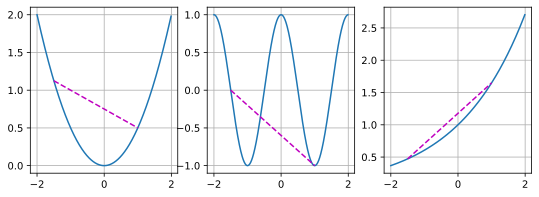

In [2]:
f = lambda x: 0.5 * x**2  # Convex
g = lambda x: torch.cos(np.pi * x)  # Nonconvex
h = lambda x: torch.exp(0.5 * x)  # Convex

x, segment = torch.arange(-2, 2, 0.01), torch.tensor([-1.5, 1])
d2l.use_svg_display()
_, axes = d2l.plt.subplots(1, 3, figsize=(9, 3))
for ax, func in zip(axes, [f, g, h]):
    d2l.plot([x, segment], [func(x), func(segment)], axes=ax)

正如预期的那样，余弦函数是*非凸*的，而抛物线和指数函数则是凸的。请注意，要求$\mathcal{X}$是一个凸集对于条件成立是必要的。否则$f(\lambda x + (1-\lambda) x')$的结果可能没有明确定义。

### Jensen's Inequality

给定一个凸函数$f$，
最有用的数学工具之一
是*Jensen's inequality*。
它相当于凸性定义的一种推广：

$$\sum_i \alpha_i f(x_i)  \geq f\left(\sum_i \alpha_i x_i\right)    \textrm{ and }    E_X[f(X)]  \geq f\left(E_X[X]\right),$$
:eqlabel:`eq_jensens-inequality`

其中$\alpha_i$是非负实数且$\sum_i \alpha_i = 1$，$X$是一个随机变量。
换句话说，凸函数的期望不低于该期望值的凸函数，后者通常是一个更简单的表达式。
为了证明第一个不等式，我们一次对总和中的一个项反复应用凸性的定义。

Jensen's inequality的一个常见应用是
通过一个更简单的表达式来限定一个更复杂的表达式。
例如，
它的应用可以
关于部分观测到的随机变量的对数似然。即我们使用

$$E_{Y \sim P(Y)}[-\log P(X \mid Y)] \geq -\log P(X),$$

因为$\int P(Y) P(X \mid Y) dY = P(X)$。
这可以在变分方法中使用。这里$Y$通常是未观察到的随机变量，$P(Y)$是对它如何分布的最佳猜测，而$P(X)$是将$Y$积分出来的分布。例如，在聚类中$Y$可能是聚类标签，$P(X \mid Y)$是在应用聚类标签时的生成模型。



## 性质

凸函数有许多有用的性质。我们在下面描述一些常用的性质。


### 局部最小值也是全局最小值

首先，凸函数的局部最小值也是全局最小值。
我们可以用反证法来证明这一点。

考虑定义在凸集$\mathcal{X}$上的凸函数$f$。
假设$x^{\ast} \in \mathcal{X}$是一个局部最小值：
存在一个小的正值$p$使得对于满足$0 < |x - x^{\ast}| \leq p$的$x \in \mathcal{X}$我们有$f(x^{\ast}) < f(x)$。

假设局部最小值$x^{\ast}$
不是$f$的全局最小值：
存在$x' \in \mathcal{X}$使得$f(x') < f(x^{\ast})$。
也存在
$\lambda \in [0, 1)$比如$\lambda = 1 - \frac{p}{|x^{\ast} - x'|}$
使得
$0 < |\lambda x^{\ast} + (1-\lambda) x' - x^{\ast}| \leq p$。

然而，
根据凸函数的定义，我们有

$$\begin{aligned}
    f(\lambda x^{\ast} + (1-\lambda) x') &\leq \lambda f(x^{\ast}) + (1-\lambda) f(x') \\
    &< \lambda f(x^{\ast}) + (1-\lambda) f(x^{\ast}) \\
    &= f(x^{\ast}),
\end{aligned}$$

这与我们的陈述$x^{\ast}$是局部最小值相矛盾。
因此，不存在$x' \in \mathcal{X}$使得$f(x') < f(x^{\ast})$。局部最小值$x^{\ast}$也是全局最小值。

例如，凸函数$f(x) = (x-1)^2$在$x=1$处有一个局部最小值，这也是全局最小值。

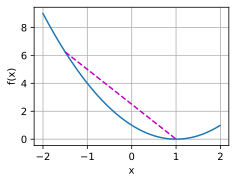

In [3]:
f = lambda x: (x - 1) ** 2
d2l.set_figsize()
d2l.plot([x, segment], [f(x), f(segment)], 'x', 'f(x)')

凸函数的局部最小值也是全局最小值，这一点非常方便。
这意味着我们在最小化函数时不会“陷入困境”。
不过需要注意的是，这并不意味着不能存在多个全局最小值，或者甚至可能不存在一个全局最小值。例如，函数 $f(x) = \mathrm{max}(|x|-1, 0)$ 在区间 $[-1, 1]$ 上达到其最小值。相反，函数 $f(x) = \exp(x)$ 在 $\mathbb{R}$ 上没有达到最小值：当 $x \to -\infty$ 时，它渐近于 $0$，但不存在 $x$ 使得 $f(x) = 0$。

### 凸函数的下水平集是凸的

我们可以通过凸函数的*下水平集*方便地定义凸集。
具体来说，
给定在凸集 $\mathcal{X}$ 上定义的凸函数 $f$，
任何下水平集

$$\mathcal{S}_b \stackrel{\textrm{def}}{=} \{x | x \in \mathcal{X} \textrm{ and } f(x) \leq b\}$$

都是凸的。

让我们快速证明这一点。回想对于任意 $x, x' \in \mathcal{S}_b$ 我们需要证明 $\lambda x + (1-\lambda) x' \in \mathcal{S}_b$ 只要 $\lambda \in [0, 1]$。
由于 $f(x) \leq b$ 和 $f(x') \leq b$，
根据凸性的定义我们有

$$f(\lambda x + (1-\lambda) x') \leq \lambda f(x) + (1-\lambda) f(x') \leq b.$$


### 凸性和二阶导数

每当函数 $f: \mathbb{R}^n \rightarrow \mathbb{R}$ 的二阶导数存在时，检查 $f$ 是否为凸函数就变得非常容易。
我们只需要检查 $f$ 的Hessian矩阵是否为半正定：$\nabla^2f \succeq 0$，即
将Hessian矩阵 $\nabla^2f$ 记作 $\mathbf{H}$，
对于所有 $\mathbf{x} \in \mathbb{R}^n$ 有 $\mathbf{x}^\top \mathbf{H} \mathbf{x} \geq 0$。
例如，函数 $f(\mathbf{x}) = \frac{1}{2} \|\mathbf{x}\|^2$ 是凸的，因为 $\nabla^2 f = \mathbf{1}$，即它的Hessian矩阵是单位矩阵。

形式上，一维二次可微函数 $f: \mathbb{R} \rightarrow \mathbb{R}$ 是凸的
当且仅当其二阶导数 $f'' \geq 0$。对于任何多维二次可微函数 $f: \mathbb{R}^{n} \rightarrow \mathbb{R}$，
它是凸的当且仅当其Hessian矩阵 $\nabla^2f \succeq 0$。

首先，我们需要证明一维情况。
为了说明 $f$ 的凸性意味着 $f'' \geq 0$，我们使用以下事实：

$$\frac{1}{2} f(x + \epsilon) + \frac{1}{2} f(x - \epsilon) \geq f\left(\frac{x + \epsilon}{2} + \frac{x - \epsilon}{2}\right) = f(x).$$

由于二阶导数由有限差分的极限给出，因此

$$f''(x) = \lim_{\epsilon \to 0} \frac{f(x+\epsilon) + f(x - \epsilon) - 2f(x)}{\epsilon^2} \geq 0.$$

为了说明 $f'' \geq 0$ 意味着 $f$ 是凸的
我们使用 $f'' \geq 0$ 意味着 $f'$ 是单调不减的事实。设 $a < x < b$ 为 $\mathbb{R}$ 中的三个点，
其中 $x = (1-\lambda)a + \lambda b$ 且 $\lambda \in (0, 1)$。
根据中值定理，
存在 $\alpha \in [a, x]$ 和 $\beta \in [x, b]$
使得

$$f'(\alpha) = \frac{f(x) - f(a)}{x-a} \textrm{ 和 } f'(\beta) = \frac{f(b) - f(x)}{b-x}.$$


通过单调性 $f'(\beta) \geq f'(\alpha)$，故

$$\frac{x-a}{b-a}f(b) + \frac{b-x}{b-a}f(a) \geq f(x).$$

由于 $x = (1-\lambda)a + \lambda b$，
我们有

$$\lambda f(b) + (1-\lambda)f(a) \geq f((1-\lambda)a + \lambda b),$$

从而证明了凸性。

其次，在证明多维情况之前我们需要一个引理：
$f: \mathbb{R}^n \rightarrow \mathbb{R}$
是凸的当且仅当对于所有 $\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$

$$g(z) \stackrel{\textrm{def}}{=} f(z \mathbf{x} + (1-z)  \mathbf{y}) \textrm{ 其中 } z \in [0,1]$$ 

是凸的。

为了证明 $f$ 的凸性意味着 $g$ 是凸的，
我们可以证明对于所有 $a, b, \lambda \in [0, 1]$（因此
$0 \leq \lambda a + (1-\lambda) b \leq 1$）

$$\begin{aligned} &g(\lambda a + (1-\lambda) b)\\
=&f\left(\left(\lambda a + (1-\lambda) b\right)\mathbf{x} + \left(1-\lambda a - (1-\lambda) b\right)\mathbf{y} \right)\\
=&f\left(\lambda \left(a \mathbf{x} + (1-a)  \mathbf{y}\right)  + (1-\lambda) \left(b \mathbf{x} + (1-b)  \mathbf{y}\right) \right)\\
\leq& \lambda f\left(a \mathbf{x} + (1-a)  \mathbf{y}\right)  + (1-\lambda) f\left(b \mathbf{x} + (1-b)  \mathbf{y}\right) \\
=& \lambda g(a) + (1-\lambda) g(b).
\end{aligned}$$

为了证明逆命题，
我们可以证明对于
所有 $\lambda \in [0, 1]$ 

$$\begin{aligned} &f(\lambda \mathbf{x} + (1-\lambda) \mathbf{y})\\
=&g(\lambda \cdot 1 + (1-\lambda) \cdot 0)\\
\leq& \lambda g(1)  + (1-\lambda) g(0) \\
=& \lambda f(\mathbf{x}) + (1-\lambda) f(\mathbf{y}).
\end{aligned}$$


最后，
利用上述引理和一维情况的结果，
多维情况
可以如下证明。
多维函数 $f: \mathbb{R}^n \rightarrow \mathbb{R}$ 是凸的
当且仅当对于所有 $\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$ $g(z) \stackrel{\textrm{def}}{=} f(z \mathbf{x} + (1-z)  \mathbf{y})$，其中 $z \in [0,1]$，
是凸的。
根据一维情况，
这成立当且仅当
$g'' = (\mathbf{x} - \mathbf{y})^\top \mathbf{H}(\mathbf{x} - \mathbf{y}) \geq 0$ ($\mathbf{H} \stackrel{\textrm{def}}{=} \nabla^2f$)
对于所有 $\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$，
等价于 $\mathbf{H} \succeq 0$
根据半正定矩阵的定义。


## 约束

凸优化的一个很好的特性是它可以有效地处理约束。也就是说，它允许我们解决*约束优化*问题，形式如下：

$$\begin{aligned} \mathop{\textrm{最小化~}}_{\mathbf{x}} & f(\mathbf{x}) \\
    \textrm{ 使得 } & c_i(\mathbf{x}) \leq 0 \textrm{ 对于所有 } i \in \{1, \ldots, n\},
\end{aligned}$$

其中 $f$ 是目标函数，函数 $c_i$ 是约束函数。要了解这做了什么，请考虑 $c_1(\mathbf{x}) = \|\mathbf{x}\|_2 - 1$ 的情况。在这种情况下，参数 $\mathbf{x}$ 被限制在单位球内。如果第二个约束是 $c_2(\mathbf{x}) = \mathbf{v}^\top \mathbf{x} + b$，那么这对应于所有 $\mathbf{x}$ 位于一个半空间内。同时满足这两个约束相当于选择球的一个切片。

### 拉格朗日函数

一般来说，解决约束优化问题是困难的。一种解决方法源自物理学，并具有相当简单的直觉。想象一个盒子内的球。球会滚到最低的地方，重力与盒子壁对球施加的力会平衡。简而言之，目标函数的梯度（即重力）将被约束函数的梯度抵消（球必须保持在盒子内，因为墙壁“推回”）。
注意，有些约束可能不活跃：
未触及球的墙壁
无法对球施加任何力。


跳过拉格朗日函数 $L$ 的推导，
上述推理
可以通过以下鞍点优化问题表达：

$$L(\mathbf{x}, \alpha_1, \ldots, \alpha_n) = f(\mathbf{x}) + \sum_{i=1}^n \alpha_i c_i(\mathbf{x}) \textrm{ 其中 } \alpha_i \geq 0.$$

这里的变量 $\alpha_i$（$i=1,\ldots,n$）是所谓的*拉格朗日乘子*，它们确保约束得到适当执行。它们被选得足够大以确保对于所有 $i$ 有 $c_i(\mathbf{x}) \leq 0$。例如，对于任何 $c_i(\mathbf{x}) < 0$ 的 $\mathbf{x}$，我们会选择 $\alpha_i = 0$。此外，这是一个鞍点优化问题，其中希望关于所有 $\alpha_i$ 最大化 $L$ 并同时关于 $\mathbf{x}$ 最小化 $L$。有大量的文献解释如何得到函数 $L(\mathbf{x}, \alpha_1, \ldots, \alpha_n)$。对于我们来说，只需知道 $L$ 的鞍点是原始约束优化问题最优解的位置即可。

### 罚项

满足约束优化问题的一种至少*近似*的方法是调整拉格朗日函数 $L$。
与其满足 $c_i(\mathbf{x}) \leq 0$，我们只需将 $\alpha_i c_i(\mathbf{x})$ 添加到目标函数 $f(x)$ 中。这确保了约束不会被严重违反。

实际上，我们一直在使用这个技巧。考虑 :numref:`sec_weight_decay` 中的权重衰减。我们在其中将 $\frac{\lambda}{2} \|\mathbf{w}\|^2$ 添加到目标函数中，以确保 $\mathbf{w}$ 不会增长得太大。从约束优化的角度来看，这将确保 $\|\mathbf{w}\|^2 - r^2 \leq 0$ 对于某个半径 $r$ 成立。调整 $\lambda$ 的值允许我们改变 $\mathbf{w}$ 的大小。

通常，添加罚项是确保近似约束满足的好方法。实际上，这比精确满足更加稳健。此外，对于非凸问题，许多使精确方法在凸情况下如此吸引人的性质（例如，最优性）不再成立。

### 投影

满足约束的另一种策略是投影。我们之前也遇到过它们，例如在 :numref:`sec_rnn-scratch` 中处理梯度裁剪时。在那里我们通过

$$\mathbf{g} \leftarrow \mathbf{g} \cdot \mathrm{min}(1, \theta/\|\mathbf{g}\|).$$

确保梯度的长度不超过 $\theta$。这实际上是将 $\mathbf{g}$ 投影到半径为 $\theta$ 的球上。更一般地，凸集 $\mathcal{X}$ 上的投影定义为

$$\textrm{Proj}_\mathcal{X}(\mathbf{x}) = \mathop{\mathrm{argmin}}_{\mathbf{x}' \in \mathcal{X}} \|\mathbf{x} - \mathbf{x}'\|,$$

这是 $\mathcal{X}$ 中离 $\mathbf{x}$ 最近的点。

![凸投影](../img/projections.svg)
:label:`fig_projections`

投影的数学定义听起来可能有点抽象。:numref:`fig_projections` 更清楚地解释了这一点。图中有两个凸集，一个圆和一个菱形。
集合内的点（黄色）在投影过程中保持不变。
集合外的点（黑色）被投影到集合内最近的点（红色）。
虽然对于 $\ell_2$ 球这种情况不会改变方向，但这在一般情况下不一定成立，如菱形的情况所示。


凸投影的一个用途是计算稀疏权重向量。在这种情况下，我们将权重向量投影到 $\ell_1$ 球上，
这是 :numref:`fig_projections` 中菱形情况的广义版本。


## 总结

在深度学习的背景下，凸函数的主要目的是激励优化算法并帮助我们详细了解它们。接下来我们将看到如何相应地推导梯度下降和随机梯度下降。


* 凸集的交集是凸的。并集则不是。
* 凸函数的期望不小于期望的凸函数（Jensen不等式）。
* 二次可微函数是凸的当且仅当其Hessian矩阵（二阶导数组成的矩阵）是半正定的。
* 可以通过拉格朗日函数添加凸约束。在实践中，我们可能只是简单地将它们作为罚项添加到目标函数中。
* 投影映射到凸集中最接近原始点的点。

## 练习

1. 假设我们想通过绘制集合内所有点之间的连线并检查这些线是否包含在集合内来验证集合的凸性。
    1. 证明只检查边界上的点就足够了。
    1. 证明只检查集合的顶点就足够了。
1. 用 $\mathcal{B}_p[r] \stackrel{\textrm{def}}{=} \{\mathbf{x} | \mathbf{x} \in \mathbb{R}^d \textrm{ and } \|\mathbf{x}\|_p \leq r\}$ 表示使用 $p$-范数的半径为 $r$ 的球。证明对于所有 $p \geq 1$，$\mathcal{B}_p[r]$ 是凸的。
1. 给定凸函数 $f$ 和 $g$，证明 $\mathrm{max}(f, g)$ 也是凸的。证明 $\mathrm{min}(f, g)$ 不是凸的。
1. 证明softmax函数的归一化是凸的。更具体地说，证明
    $f(x) = \log \sum_i \exp(x_i)$ 的凸性。
1. 证明线性子空间，即 $\mathcal{X} = \{\mathbf{x} | \mathbf{W} \mathbf{x} = \mathbf{b}\}$，是凸集。
1. 证明在线性子空间的情况下，当 $\mathbf{b} = \mathbf{0}$ 时，投影 $\textrm{Proj}_\mathcal{X}$ 可以写成 $\mathbf{M} \mathbf{x}$ 的形式，其中 $\mathbf{M}$ 是某个矩阵。
1. 证明对于二次可微的凸函数 $f$，我们可以写成 $f(x + \epsilon) = f(x) + \epsilon f'(x) + \frac{1}{2} \epsilon^2 f''(x + \xi)$ 的形式，其中 $\xi \in [0, \epsilon]$。
1. 给定凸集 $\mathcal{X}$ 和两个向量 $\mathbf{x}$ 和 $\mathbf{y}$，证明投影永远不会增加距离，即 $\|\mathbf{x} - \mathbf{y}\| \geq \|\textrm{Proj}_\mathcal{X}(\mathbf{x}) - \textrm{Proj}_\mathcal{X}(\mathbf{y})\|$。


[讨论](https://discuss.d2l.ai/t/350)